1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import *

In [3]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('C:/Users/alifa/.fastai/data/mnist_png/testing'),Path('C:/Users/alifa/.fastai/data/mnist_png/training')]

In [4]:
train_data = (path/'training').ls().sorted()
test_data = (path/'testing').ls().sorted()

In [5]:
tensors = {}
for path in train_data:
    tensors[path.name] = [tensor(Image.open(o)) for o in path.ls()]

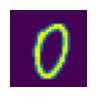

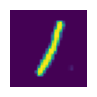

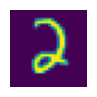

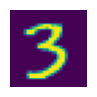

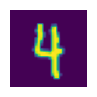

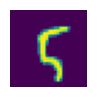

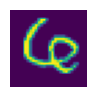

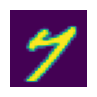

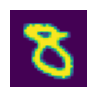

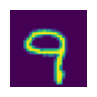

In [6]:
for t in tensors.keys():
    show_image(tensors[t][1])

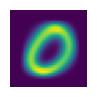

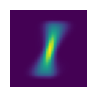

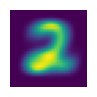

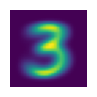

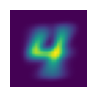

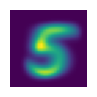

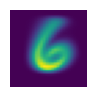

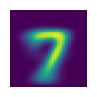

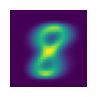

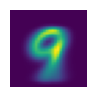

In [7]:
stacked_tensors = {t: torch.stack(tensors[t]).float()/255 for t in tensors.keys()}

for k in stacked_tensors.keys():
    img = stacked_tensors[k].mean(0)
    show_image(img)


<Axes: >

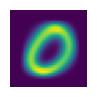

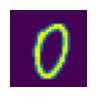

In [8]:
mean_0 = stacked_tensors['0'].mean(0)
show_image(mean_0)

a_0 = stacked_tensors['0'][1]
show_image(a_0)

## Test for 0

In [9]:
dist_abs = (a_0 - mean_0).abs().mean()
dist_sqr = ((a_0 - mean_0)**2).mean().sqrt()

dist_abs,dist_sqr

(tensor(0.1388), tensor(0.2400))

## Test For 3

(tensor(0.1114), tensor(0.2021))

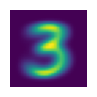

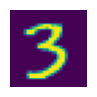

In [10]:
mean_3 = stacked_tensors['3'].mean(0)
a_3 = stacked_tensors['3'][1]
show_image(mean_3),show_image(a_3)


dist_abs = (a_3 - mean_3).abs().mean()
dist_sqr = ((a_3 - mean_3)**2).mean().sqrt()

dist_abs,dist_sqr

In [11]:
l1_l = F.l1_loss(a_3.float(),mean_3)
mse_l = F.mse_loss(a_3.float(),mean_3).sqrt()

l1_l,mse_l

(tensor(0.1114), tensor(0.2021))

## Train and Validation split

In [12]:
train = {}
valid = {}

for key in stacked_tensors.keys():
    length = len(stacked_tensors[key])
    train_size = math.floor(0.8 * length)
    valid_size = length - train_size
    
    [train_split, valid_split] = torch.utils.data.random_split(stacked_tensors[key], [train_size, valid_size])
    
    train_data = [stacked_tensors[key][i] for i in train_split.indices]
    valid_data = [stacked_tensors[key][i] for i in valid_split.indices]
    
    train_tensor = torch.stack(train_data)
    valid_tensor = torch.stack(valid_data)
    
    train[key] = train_tensor
    valid[key] = valid_tensor 

In [13]:
train,valid

({'0': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...

<Axes: >

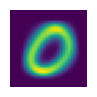

In [14]:
train_means = {key:train[key].mean(0) for key in train.keys()}
show_image(train_means['0'])

In [15]:
def determine_digits(img_tensors):
    digits = []
    
    for img in img_tensors:
        dists = {}
        
        for k in train_means.keys():
            dists[k] = F.l1_loss(img,train_means[k])
            
        sorted_list = sorted(list(dists.items()),key = lambda x:x[1])
        digits.append(sorted_list[0][0])
        
    return digits   
        

In [16]:
preds = {}
acc = {}

for k in train_means.keys():
    preds[k] = determine_digits(valid[k])
    accuracy = (sum([1 if pred == k else 0 for pred in preds[k]])) / len(preds[k])
    acc[k] = accuracy
    
total = 0
for digit,accuracy in acc.items():
    total += accuracy
    print(digit,round(accuracy,3))
    
print(total/10)

KeyboardInterrupt: 

# Machine Learning

In [1]:
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *

In [2]:
import numpy as np

path = untar_data(URLs.MNIST)
train_path = (path/'training').ls().sorted()
tensors = [(tensor(Image.open(img)),int(path.name)) for path in train_path for img in path.ls()]

np.random.shuffle(tensors)

index = math.floor(len(tensors) * 0.8)
train,valid = tensors[:index],tensors[index:]

In [3]:
train_X = torch.cat([train[i][0].view(-1,784).float()/255 for i in range(len(train))])
train_Y = tensor([train[i][1] for i in range(len(train))])

dset = list(zip(train_X,train_Y))

In [4]:
valid_X = torch.cat([valid[i][0].view(-1,28*28).float()/255 for i in range(len(valid))])
valid_Y = tensor([valid[i][1] for i in range(len(valid))])
valid_dset = list(zip(valid_X,valid_Y))

In [16]:
class Learner():
    def __init__(self) -> None:
        self.weights_ = self.init_params((28*28),10)
        self.bias_ = self.init_params((1,10))
        
    def init_params(self,size,std =1.0):
        return (torch.randn(size)*std).requires_grad_()
    
    def linear1(self,xb):
        return xb @ self.weights_ + self.bias_
    
    def softmax(self,x):
        e_x = np.exp(x - np.max(x))
        return e_x/e_x.sum(axis = 0)
        

In [17]:
model = Learner()
pred = (train_X[0]*model.weights_.T).sum() + model.bias_
pred

tensor([[-24.2841, -25.6929, -25.2876, -24.2985, -25.5399, -23.6674, -23.7519, -23.8390, -23.9374, -22.6594]], grad_fn=<AddBackward0>)

In [20]:
torch.set_printoptions(sci_mode=False)
model = Learner()
preds = model.linear1(train_X)
preds = model.softmax(preds)
preds[2]